In [2]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole  # Jupyter上で分子構造表示可能にする
from rdkit.Chem import AllChem
import py3Dmol

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# SMILESの扱い

In [3]:
smiles_list = [
    "C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=CC=C3",  # トリフェニルアミン
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C4=CC=CC=C4)C5=CC=C(C=C5)C6=CC=CC=C6",
    "C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C4=CC=C(C=C4)N(C5=CC=CC=C5)C6=CC=CC=C6",
    "C1=CC=C2C(=C1)C=CC=C2C3=CC=C(C=C3)N(C4=CC=C(C=C4)C5=CC=CC6=CC=CC=C65)C7=CC=C(C=C7)C8=CC=CC9=CC=CC=C98"
]

In [4]:
# SMILESをカノニカル化（正規化）
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, canonical=True)
    else:
        return None

for i, smiles in enumerate(smiles_list):
    canonical_smiles = canonicalize_smiles(smiles)
    if canonical_smiles:
        smiles_list[i] = canonical_smiles
        
smiles_list

['c1ccc(N(c2ccccc2)c2ccccc2)cc1',
 'c1ccc(-c2ccc(N(c3ccc(-c4ccccc4)cc3)c3ccc(-c4ccccc4)cc3)cc2)cc1',
 'c1ccc(N(c2ccccc2)c2ccc(-c3ccc(N(c4ccccc4)c4ccccc4)cc3)cc2)cc1',
 'c1ccc2c(-c3ccc(N(c4ccc(-c5cccc6ccccc56)cc4)c4ccc(-c5cccc6ccccc56)cc4)cc3)cccc2c1']

# 分子の描画

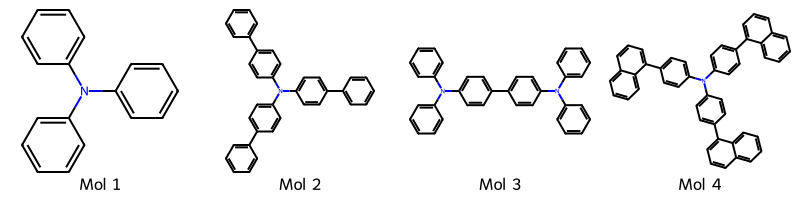

In [5]:
# --- SMILESからMolオブジェクトに変換 ---
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# --- 分子構造をJupyter上で可視化（2D） ---
Draw.MolsToImage(mols, subImgSize=(200, 200), legends=[f"Mol {i+1}" for i in range(len(mols))])

In [6]:
mols

In [7]:
# Smilesの長さ
smiles_lengths = [len(smiles) for smiles in smiles_list]

# CとNのカウント
c_counts = [smiles.count('c') for smiles in smiles_list]
n_counts = [smiles.count('N') for smiles in smiles_list]

c_counts

[18, 36, 36, 48]

In [8]:
# 3次元構造の可視化
def show_3d(mol):
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    mb = Chem.MolToMolBlock(mol)
    
    viewer = py3Dmol.view(width=400, height=300)
    viewer.addModel(mb, "mol")
    viewer.setStyle({"stick": {}})
    viewer.setBackgroundColor("0xeeeeee")
    viewer.zoomTo()
    return viewer.show()

show_3d(mols[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# 分子の類似度（tanimoto係数）

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from rdkit import DataStructs

In [10]:
# FPを生成する関数
def generate_fingerprints(smiles_list, fp_type):
    """
    fp_type : int
        フィンガープリント種別
        0: MACCS key
        1: RDKit
        2: Morgan
        3: Avalon
    """
    fp_list = []
    
    morgan_gen = None
    if fp_type == 2:
        morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

    for smiles_i in smiles_list:
        mol = Chem.MolFromSmiles(smiles_i)
        if mol is None:
            fp_list.append(None)
            continue

        if fp_type == 0:
            fp_list.append(AllChem.GetMACCSKeysFingerprint(mol))
        elif fp_type == 1:
            fp_list.append(Chem.RDKFingerprint(mol))
        elif fp_type == 2:
            fp_list.append(morgan_gen.GetFingerprint(mol))
        elif fp_type == 3:
            fp_list.append(GetAvalonFP(mol))
        else:
            raise ValueError(f"Invalid fp_type: {fp_type}")
        
    fp_list = pd.DataFrame(np.array(fp_list, int))
    
    fp_names = []
    for i in range(len(fp_list.columns)):
        fp_names.append(f"FP_{i}")
    fp_list.columns = fp_names

    return fp_list

In [11]:
fps_0 = generate_fingerprints(smiles_list, 0)
fps_1 = generate_fingerprints(smiles_list, 1)
fps_2 = generate_fingerprints(smiles_list, 2)
fps_3 = generate_fingerprints(smiles_list, 3)


In [12]:
# FPを作成
maccs_fps = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mols]

rdkit_fps = [Chem.RDKFingerprint(mol) for mol in mols]

morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
morgan_fps = [morgan_gen.GetFingerprint(mol) for mol in mols]

Avalon_fps = [GetAvalonFP(mol) for mol in mols]

In [13]:
rdkit_fps

In [14]:
# --- 分子間類似度（Tanimoto係数）を計算 ---
for i in range(len(rdkit_fps) - 1):
    for j in range(i + 1, len(rdkit_fps)):
        print(f"Tanimoto similarity between mol_{i} and mol_{j}:")
        print(f"{DataStructs.TanimotoSimilarity(rdkit_fps[i], rdkit_fps[j]):.3f}")

Tanimoto similarity between mol_0 and mol_1:
0.580
Tanimoto similarity between mol_0 and mol_2:
0.580
Tanimoto similarity between mol_0 and mol_3:
0.404
Tanimoto similarity between mol_1 and mol_2:
1.000
Tanimoto similarity between mol_1 and mol_3:
0.697
Tanimoto similarity between mol_2 and mol_3:
0.697


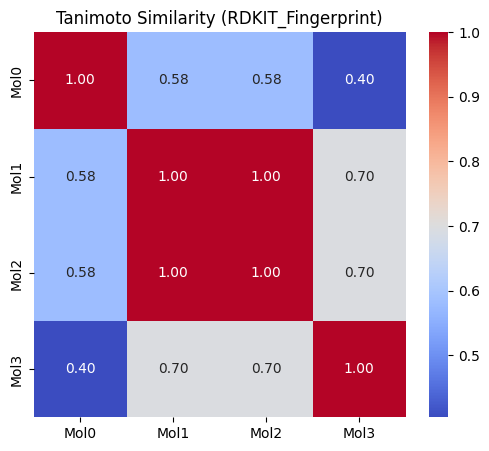

In [15]:
# ヒートマップを描画
def compute_similarity_matrix(fp_list):
    n = len(fp_list)
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
    return pd.DataFrame(sim_matrix, columns=[f"Mol{i}" for i in range(n)], index=[f"Mol{i}" for i in range(n)])

sim_rdkit = compute_similarity_matrix(rdkit_fps)

# ヒートマップで可視化
plt.figure(figsize=(6, 5))
sns.heatmap(sim_rdkit, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tanimoto Similarity (RDKIT_Fingerprint)")
plt.show()

In [16]:
for i in range(len(morgan_fps) - 1):
    for j in range(i + 1, len(morgan_fps)):
        print(f"Tanimoto similarity between mol_{i} and mol_{j}:")
        print(f"{DataStructs.TanimotoSimilarity(morgan_fps[i], morgan_fps[j]):.3f}")

Tanimoto similarity between mol_0 and mol_1:
0.647
Tanimoto similarity between mol_0 and mol_2:
0.750
Tanimoto similarity between mol_0 and mol_3:
0.385
Tanimoto similarity between mol_1 and mol_2:
0.882
Tanimoto similarity between mol_1 and mol_3:
0.481
Tanimoto similarity between mol_2 and mol_3:
0.481


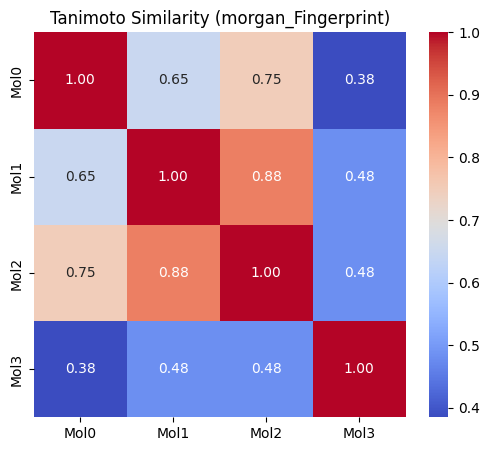

In [17]:
sim_morgan = compute_similarity_matrix(morgan_fps)

# ヒートマップで可視化
plt.figure(figsize=(6, 5))
sns.heatmap(sim_morgan, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tanimoto Similarity (morgan_Fingerprint)")
plt.show()

# 重水素化SMIELESの処理

In [23]:
def remove_isotopes(smiles_list):
    """
    重水素（[2H]）や三重水素（[3H]）を通常の水素として扱い、
    [H]表記が残らない自然なSMILESに変換する関数。
    
    Parameters
    ----------
    smiles_list : list of str
        SMILES文字列のリスト
    
    Returns
    -------
    list of str
        同位体情報を削除したSMILESリスト
    """
    cleaned_smiles = []
    
    for smi in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                cleaned_smiles.append(None)
                continue

            # 各原子の同位体情報をリセット
            for atom in mol.GetAtoms():
                atom.SetIsotope(0)

            # 明示的な水素を暗黙的に変換（[H] → 暗黙水素）
            mol = Chem.RemoveHs(mol)

            # Canonical SMILESとして再生成
            smiles_no_iso = Chem.MolToSmiles(mol, canonical=True)
            cleaned_smiles.append(smiles_no_iso)

        except Exception:
            cleaned_smiles.append(None)
    
    return cleaned_smiles



In [24]:
smiles_list = [
    "CC[2H]",     # 重水素付きエタン
    "C[3H]C(=O)O", # 三重水素付き酢酸
    "CCO",         # 通常のエタノール
]

print(remove_isotopes(smiles_list))


['CC', None, 'CCO']


[05:40:18] Explicit valence for atom # 1 H, 2, is greater than permitted


In [25]:
import re
from rdkit import Chem

# 同位体トークンを削除する正規表現（[2H], [3H], [D], [T] を扱う）
_ISOTOPE_PATTERN = re.compile(r'\[(?:2H|3H|D|T)\]')

def remove_h_isotopes_from_smiles(smiles_list):
    """
    SMILESリスト中の重水素/三重水素などの同位体表記を削除して、
    通常の（同位体を無視した）SMILESに変換する関数。

    Parameters
    ----------
    smiles_list : list of str
        入力SMILESのリスト

    Returns
    -------
    list of str or None
        同位体を削除したSMILESのリスト。変換できなかった要素はNone。
    """
    out = []
    for smi in smiles_list:
        if smi is None:
            out.append(None)
            continue

        # 1) テキストレベルで [2H], [3H], [D], [T] を削除しておく（例: C[2H]C -> CC）
        smi_fixed = _ISOTOPE_PATTERN.sub('', smi)

        # 2) RDKitでパース
        mol = Chem.MolFromSmiles(smi_fixed)
        if mol is None:
            # 万一まだパースできないなら、安全に None を返す
            out.append(None)
            continue

        # 3) もし明示水素が残っていたら暗黙水素に戻す
        try:
            mol = Chem.RemoveHs(mol)
        except Exception:
            # RemoveHs で問題が起こればそのまま進める（既に大抵大丈夫）
            pass

        # 4) 同位体情報を念のためクリア（保険）
        for atom in mol.GetAtoms():
            atom.SetIsotope(0)

        # 5) Canonical SMILES を返す
        smiles_no_iso = Chem.MolToSmiles(mol, canonical=True)
        out.append(smiles_no_iso)

    return out


In [26]:
smiles_list = [
    "CC[2H]",         # 重水素付きエタン（末端）
    "C[3H]C(=O)O",    # 三重水素が書かれた酢酸誘導体（以前は None になった）
    "CCO",            # 通常のエタノール
    "[2H]C1=CC=CC=C1" # 芳香環上に明示されたD（例）
]

print(remove_h_isotopes_from_smiles(smiles_list))


['CC', 'CC(=O)O', 'CCO', 'c1ccccc1']


In [18]:
# !jupyter nbconvert --to html RDKIT_basic.ipynb